In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
import pymc as pm
print(f"Running on PyMC v{pm.__version__}") 
import arviz as az

Running on PyMC v5.8.0


## Ex3. Beta-Binomial models... Multicenter trials

Example 3. (Pooled, Unpooled, Hierarchical model)

**Multicenter trials: Beta-Binomial model** 

- What is the overall success rate? 
- Are all center-specific effects the same? How to obtain center-specific effect?
- What would be the variability?
- Anything unusual in any clinical center?

| **Hospital** | **Success** |   |   |   | **Hospital** | **Success** |
|:------------:|:-----------:|---|---|---|:------------:|:-----------:|
|       1      |      18     |   |   |   |       9      |      16     |
|       2      |      10     |   |   |   |      10      |      16     |
|       3      |      19     |   |   |   |      11      |      18     |
|       4      |      13     |   |   |   |      12      |      17     |
|       5      |      17     |   |   |   |      13      |      10     |
|       6      |      10     |   |   |   |      14      |      19     |
|       7      |      12     |   |   |   |      15      |      13     |
|       8      |      19     |   |   |   |      16      |      16     |     16 | 16     | 16     |   16   |   16   |   16   |

### Beta-Binomial models (1)

16家醫院參加某癌症藥物的臨床試驗，每家招募
20人，假設藥效成功率為 $p$ ，請問該藥效能勝過傳統藥物藥效0.8的機率為多少?

Same effect $\textcolor{red}p$ for all $K=16$ centers:
\begin{align*}
      Y_i \mid p &\sim \text{Binomial}(n=20, \textcolor{red}p) \\
     p \mid \alpha, \beta  &\sim \text{Beta}(\alpha = 3 , \beta = 3) 
\end{align*}

- $Y_i$ : number of success ,      $i=1,...,K$. 
- $\textcolor{red}p$ :  effect p (overall success rate)
- $n$ : (n=20) number of patient in each center

In [ ]:
Y_data = np.array([18,10,19,13,17,10,12,19,16,16,18,17,10,19,13,16]) #Success
k = len(Y_data) #i=1,2,...,16
n = 20

In [ ]:
gv = pm.model_graph.model_to_graphviz(model=m_bb1)
gv.format = 'png'
gv.render(filename='ex_3_1_hospital')

### Beta-Binomial models (2)

16家醫院參加某癌症藥物的臨床試驗，每家招募
20人，假設藥效成功率為 $\textcolor{red}{p_i}$ ，請問該藥效能勝過傳
統藥物藥效0.8的機率為多少?

Different effects $\textcolor{red}{p_i}$ for $K=16$ centers:

\begin{align*}
      Y_i \mid \textcolor{red}{p_i} &\sim \text{Binomial}(n=20, \textcolor{red}{p_i}) \\
      \textcolor{red}{p_i} \mid \alpha, \beta  &\sim \text{Beta}(\alpha = 3 , \beta = 3)\\ 
\end{align*}

- $Y_i$: number of success ,      $i=1,...,K$ 
- $\color{red}{p_𝑖}$: effect p (success rate) for center $i$,  $i=1,...,K$
- $n$: (n=20) number of patients in each center

In [30]:
#DataFrame example:
hostpital_name=['h01','h02','h03','h04','h05','h06','h07','h08','h09',
                'h10','h11','h12','h13','h14','h15','h16']
y_list=[18,10,19,13,17,10,12,19,16,16,18,17,10,19,13,16]

bb_df = {"Hospital":pd.Series(hostpital_name, dtype='category'),
        "Success": y_list}
bb_df = pd.DataFrame(bb_df)
bb_df

,Hospital,Success
0,h01,18
1,h02,10
2,h03,19
3,h04,13
4,h05,17
5,h06,10
6,h07,12
7,h08,19
8,h09,16
9,h10,16


In [31]:
#Index: Array, dtype=int8  array([0,1,2,3,...])
Hosp_idx = bb_df.Hospital.cat.codes.values
#Label: Array, object (category)['h01','h02','h03','h04'...]
Hosp_labels = bb_df.Hospital.cat.categories 

$\uparrow$ same as using `Hosp_idx,Hosp_labels = pd.factorize(bb_df["Hospital"])`

- 1. Using `coords` & `dims`:

In [32]:
coords = {"Hospital": Hosp_labels,        # Label/Name for the hospital 
          "Hosp_idx":Hosp_idx,            # Index for the hospital
         "obs_id": np.arange(len(bb_df))} # Index for the dataframe

In [33]:
with pm.Model(coords=coords) as m_bb2: 
    # Prior
    p = pm.Beta('p', alpha=3, beta=3, dims="Hospital")
    # Likelihood
    y = pm.Binomial('y', n=20, p=p[Hosp_idx],
                    dims="obs_id",
                    observed = bb_df["Success"]) # bb_df.Success.values

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


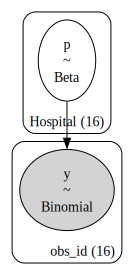

In [34]:
pm.model_to_graphviz(model=m_bb2)

In [39]:
gv = pm.model_graph.model_to_graphviz(model=m_bb2)
gv.format = 'png'
gv.render(filename='ex_3_2_1_hospital')

'ex_3_2_1_hospital.png'

In [43]:
with m_bb2:
    idata_bb2 = pm.sample(draws=500, random_seed=101)

az.summary(idata_bb2,hdi_prob=0.95,round_to=3) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 15 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p[h01],0.809,0.077,0.666,0.945,0.001,0.001,3059.499,1427.129,1.002
p[h02],0.498,0.099,0.305,0.679,0.002,0.001,3790.366,1414.528,1.005
p[h03],0.845,0.069,0.713,0.969,0.001,0.001,4268.063,1305.062,1.003
p[h04],0.615,0.095,0.416,0.785,0.002,0.001,3714.264,1380.623,1.007
p[h05],0.772,0.079,0.615,0.908,0.001,0.001,3993.681,1569.872,1.003
p[h06],0.498,0.097,0.308,0.683,0.002,0.001,3719.481,1576.594,1.001
p[h07],0.577,0.093,0.402,0.759,0.001,0.001,3787.840,1349.907,1.002
p[h08],0.844,0.073,0.706,0.960,0.001,0.001,3365.301,1287.451,1.003
p[h09],0.730,0.086,0.563,0.898,0.001,0.001,3329.958,1629.089,1.001
p[h10],0.731,0.087,0.559,0.889,0.001,0.001,3651.260,1344.456,1.002


- 2. Using `shape`:

$\downarrow$Same as using `shape` argument.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 15 seconds.


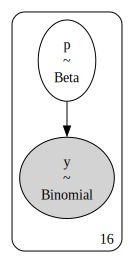

In [36]:
k = len(bb_df)

with pm.Model( ) as bb2_s: 
    # Prior
    p = pm.Beta('p', alpha=3, beta=3, shape=k) # k=16 
    # Likelihood
    y = pm.Binomial('y', n=20, p=p[Hosp_idx],
                    observed = bb_df["Success"])

pm.model_to_graphviz(model=bb2_s1)

In [38]:
gv = pm.model_graph.model_to_graphviz(model=bb2_s)
gv.format = 'png'
gv.render(filename='ex_3_2_2_hospital')

'ex_3_2_2_hospital.png'

In [40]:
with pm.Model( ) as bb2_s: 
    idata_bb2s = pm.sample(draws=500, random_seed=101)
az.summary(idata_bb2s, hdi_prob=0.95, round_to=3) 

C:\Users\Yvonne\anaconda3\envs\pymc_test3\Lib\site-packages\arviz\utils.py:134: UserWarning: Items starting with ~: ['lambda_poi'] have not been found and will be ignored
  warnings.warn(


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p[0],0.809,0.077,0.666,0.945,0.001,0.001,3059.499,1427.129,1.002
p[1],0.498,0.099,0.305,0.679,0.002,0.001,3790.366,1414.528,1.005
p[2],0.845,0.069,0.713,0.969,0.001,0.001,4268.063,1305.062,1.003
p[3],0.615,0.095,0.416,0.785,0.002,0.001,3714.264,1380.623,1.007
p[4],0.772,0.079,0.615,0.908,0.001,0.001,3993.681,1569.872,1.003
p[5],0.498,0.097,0.308,0.683,0.002,0.001,3719.481,1576.594,1.001
p[6],0.577,0.093,0.402,0.759,0.001,0.001,3787.840,1349.907,1.002
p[7],0.844,0.073,0.706,0.960,0.001,0.001,3365.301,1287.451,1.003
p[8],0.730,0.086,0.563,0.898,0.001,0.001,3329.958,1629.089,1.001
p[9],0.731,0.087,0.559,0.889,0.001,0.001,3651.260,1344.456,1.002


#### Region of Practical Equivalence (ROPE)

The ROPE is shown as a thick light line. 

And the black line is for 95% HDI.

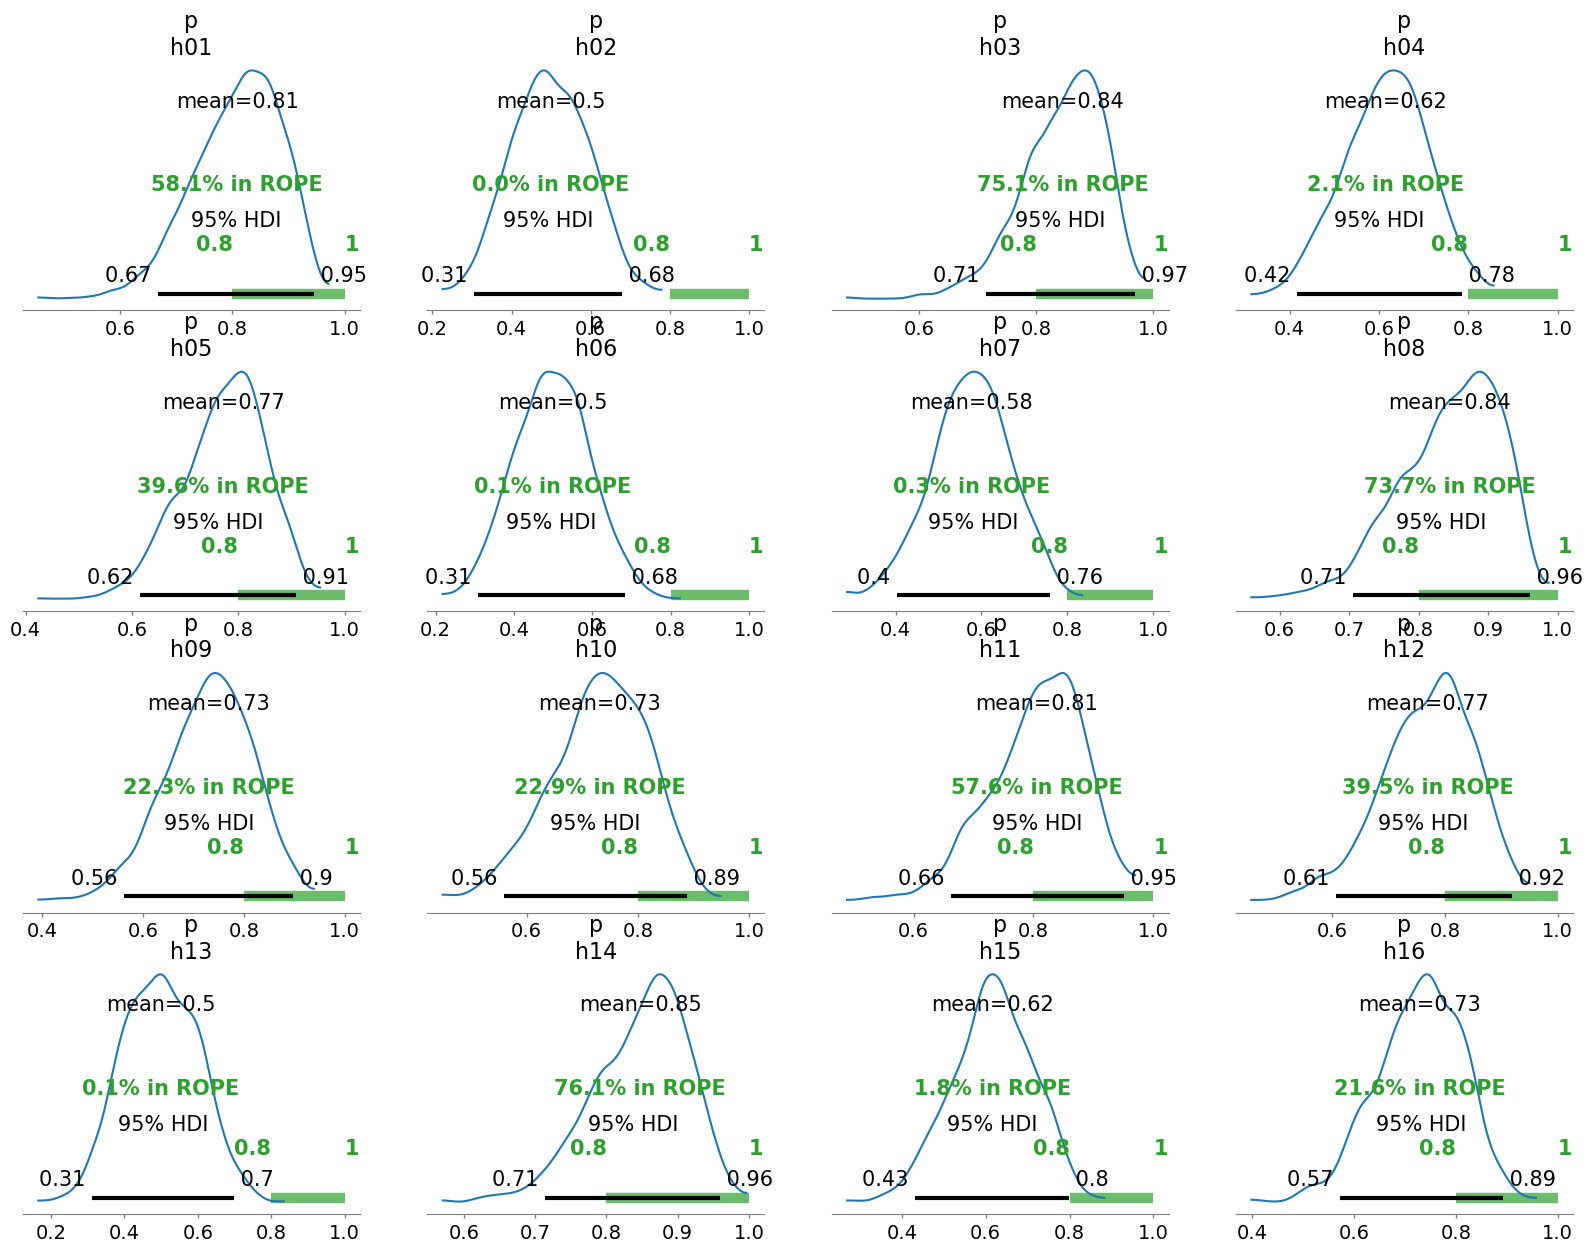

In [44]:
az.plot_posterior(idata_bb2, rope=[0.8, 1], 
                  hdi_prob=0.95, 
                  figsize=(20, 15)) 
plt.show()

請問該藥效能勝過傳統藥物藥效 0.8 的機率為多少?

`ref_val`: Display the percentage below and above the values in ref_val.

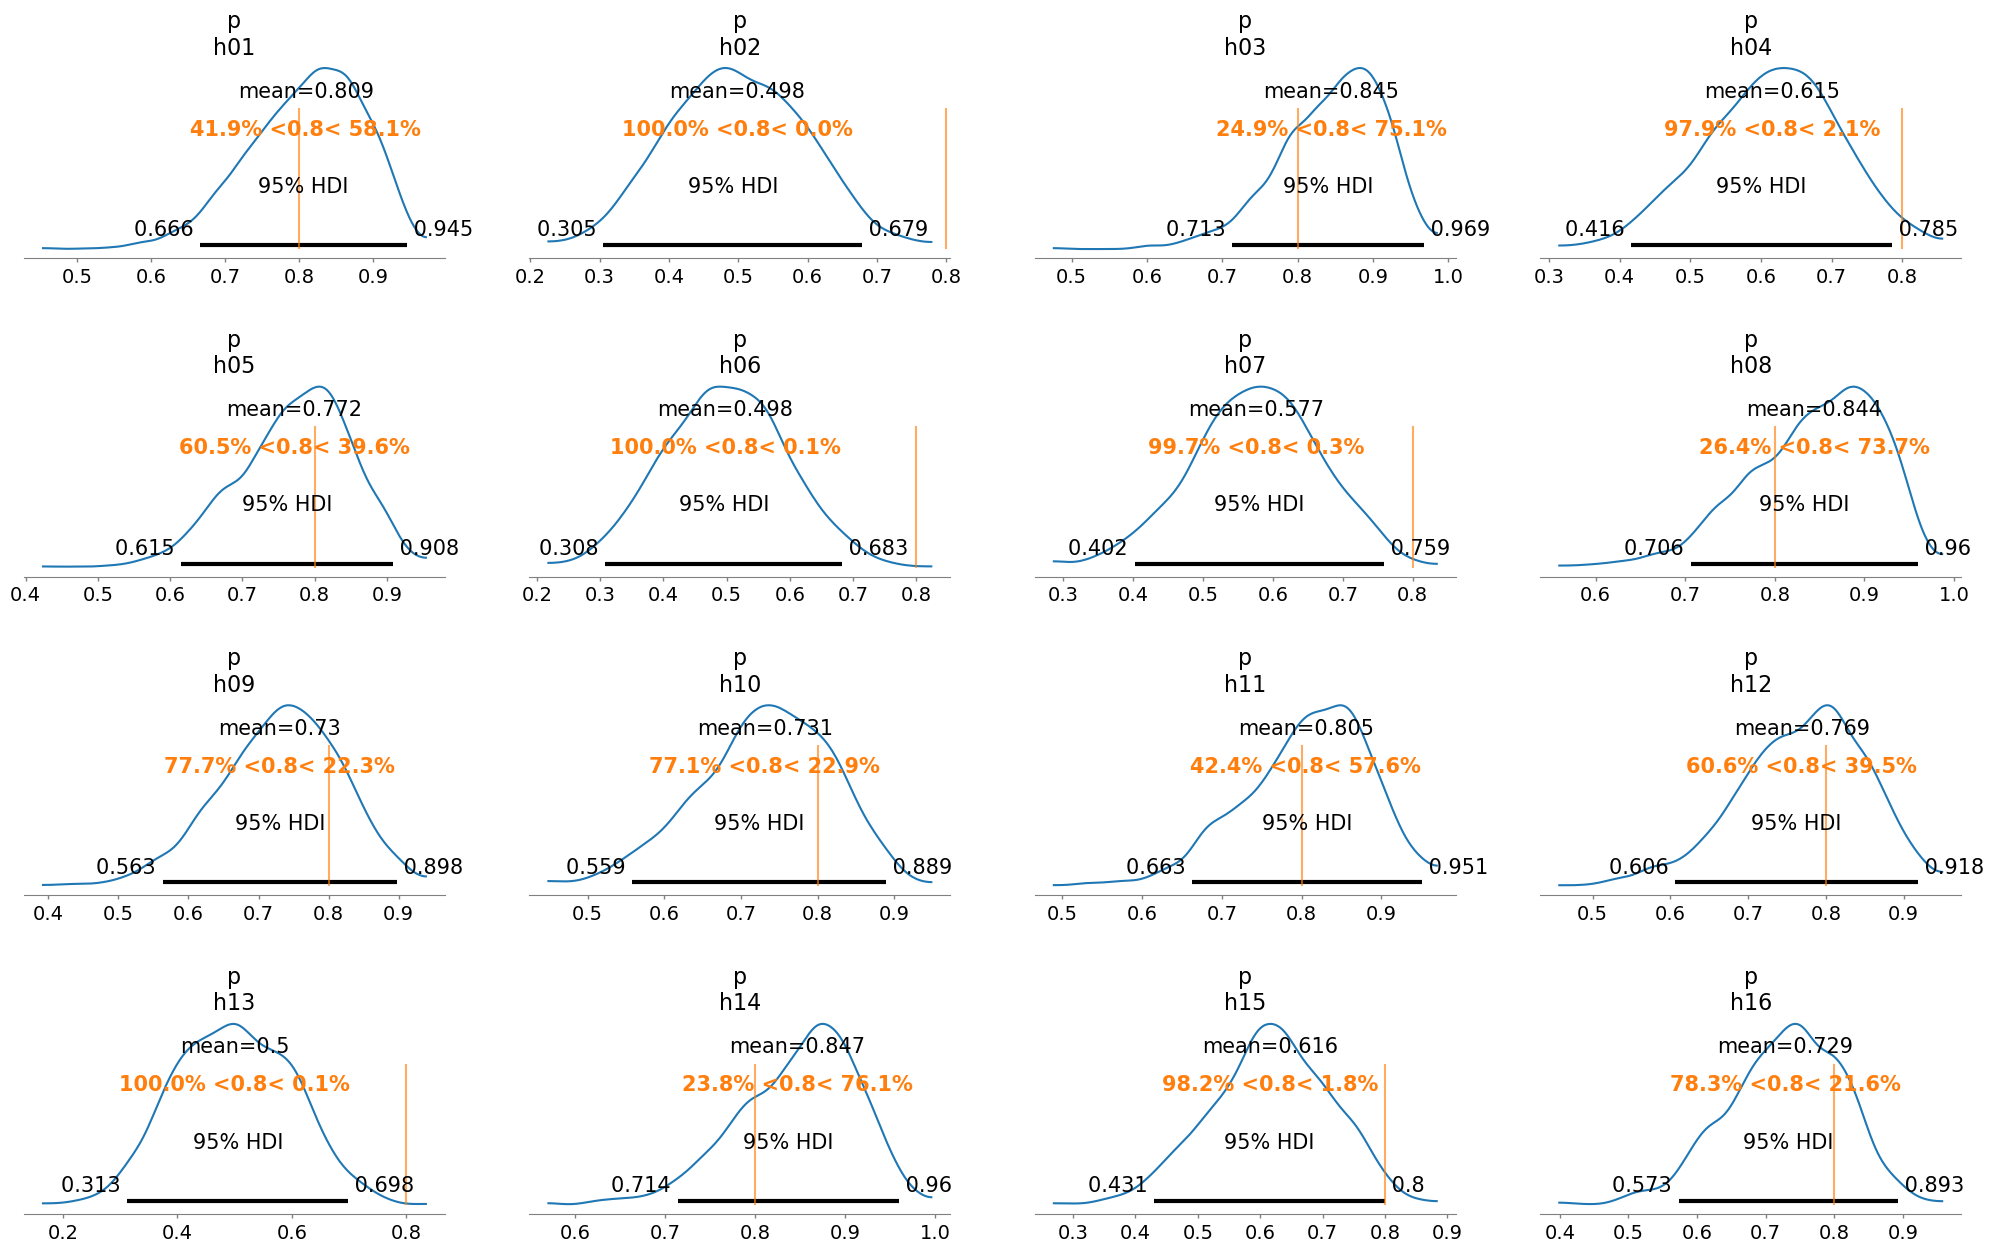

In [45]:
az.plot_posterior(idata_bb2, hdi_prob=0.95, ref_val=0.8, round_to=3, figsize=(25, 15))
plt.subplots_adjust(hspace=0.6) #Add some subplot upper space
plt.show()

### Beta-Binomial models(2-parameter) (3)

16家醫院參加某癌症藥物的臨床試驗，每家招募20人，假設藥效成功率為 $\textcolor{red}{p_i}$ ，請問該藥效能勝過傳統藥物藥效0.8的機率為多少?

Different effects $\textcolor{red}{p_i}$ for $K=16$ centers:

Likelihood  & prior:
\begin{align*}
      Y_i \mid \textcolor{red}{p_i} &\sim \text{Binomial}(n=20, \textcolor{red}{p_i}) \\
      \textcolor{red}{p_i} \mid \alpha, \beta  &\sim \text{Beta}(\alpha , \beta)\\ \\
\end{align*}
Hyper prior:
\begin{align*}
      \textcolor{blue}{\theta = \alpha / (\alpha + \beta)}  &\sim \text{Beta}( 6, 3)\\
      \textcolor{blue}{\omega = 1 / (\alpha + \beta)}  &\sim \text{Beta}( 1, 3)
\end{align*}



其中，"Target"為
\begin{align*}
E(p_i) &= \theta \\
Var(p_i)&= \theta (1-\theta) \omega
\end{align*}

也可以從$\theta$,$\omega$回推(寫在pm.Deterministic)
\begin{align*}
\alpha &= \theta / \omega \\
\beta &= (1-\theta) / \omega
\end{align*}

- $Y_i$: number of success ,      $i=1,...,K$ 
- $\color{red}{p_i}$: effect $\color{red}{p}$ (success rate) for center $i$,  $i=1,...,K$
- $n$: (n=20) number of patient in each centers)

In [50]:
coords = {"Hospital": Hosp_labels,        # Label/Name for the hospital 
          "Hosp_idx":Hosp_idx,            # Index for the hospital
         "obs_id": np.arange(len(bb_df))} # Index for the dataframe

In [51]:
with pm.Model(coords=coords) as m_bb3: 
    # Hyper parameters
    theta= pm.Beta('theta', alpha=6, beta=3) #E(p_i)
    omega= pm.Beta('omega', alpha=1, beta=3)

    alpha=pm.Deterministic("alpha", theta/omega)
    beta=pm.Deterministic("beta", (1-theta)/omega)

    var_p=pm.Deterministic("var_p",theta*(1-theta)*omega) #Var(p_i)
                           
    # Prior
    p = pm.Beta('p', alpha=alpha, beta=beta, dims="Hospital") 

    # Likelihood
    y = pm.Binomial('y', n=20, p=p[Hosp_idx], observed=bb_df["Success"], dims="obs_id") 

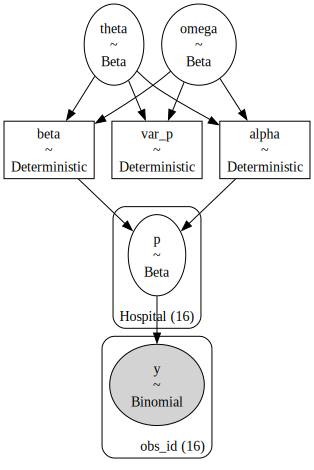

In [52]:
pm.model_to_graphviz(model=m_bb3)

In [53]:
gv = pm.model_graph.model_to_graphviz(model=m_bb3)
gv.format = 'png'
gv.render(filename='ex_3_3_hospital')

'ex_3_3_hospital.png'

In [55]:
with m_bb3: 
    idata_bb3 = pm.sample(draws=500, random_seed=101)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, omega, p]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 17 seconds.


In [56]:
az.summary(idata_bb3, hdi_prob=0.95).round(2)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.74,0.04,0.66,0.83,0.00,0.00,2269.0,1596.0,1.00
omega,0.15,0.08,0.03,0.28,0.00,0.00,1234.0,885.0,1.00
p[h01],0.86,0.07,0.73,0.97,0.00,0.00,3071.0,1199.0,1.00
p[h02],0.57,0.10,0.38,0.77,0.00,0.00,2903.0,1632.0,1.00
p[h03],0.89,0.06,0.78,1.00,0.00,0.00,2589.0,1244.0,1.00
p[h04],0.68,0.09,0.50,0.84,0.00,0.00,3357.0,1563.0,1.00
p[h05],0.82,0.08,0.66,0.95,0.00,0.00,3922.0,1212.0,1.00
p[h06],0.57,0.10,0.36,0.75,0.00,0.00,3253.0,1544.0,1.00
p[h07],0.64,0.09,0.45,0.81,0.00,0.00,3453.0,1179.0,1.00
p[h08],0.89,0.06,0.78,0.99,0.00,0.00,2585.0,1138.0,1.00


請問該藥效能勝過傳統藥物藥效0.8的 機率為多少?

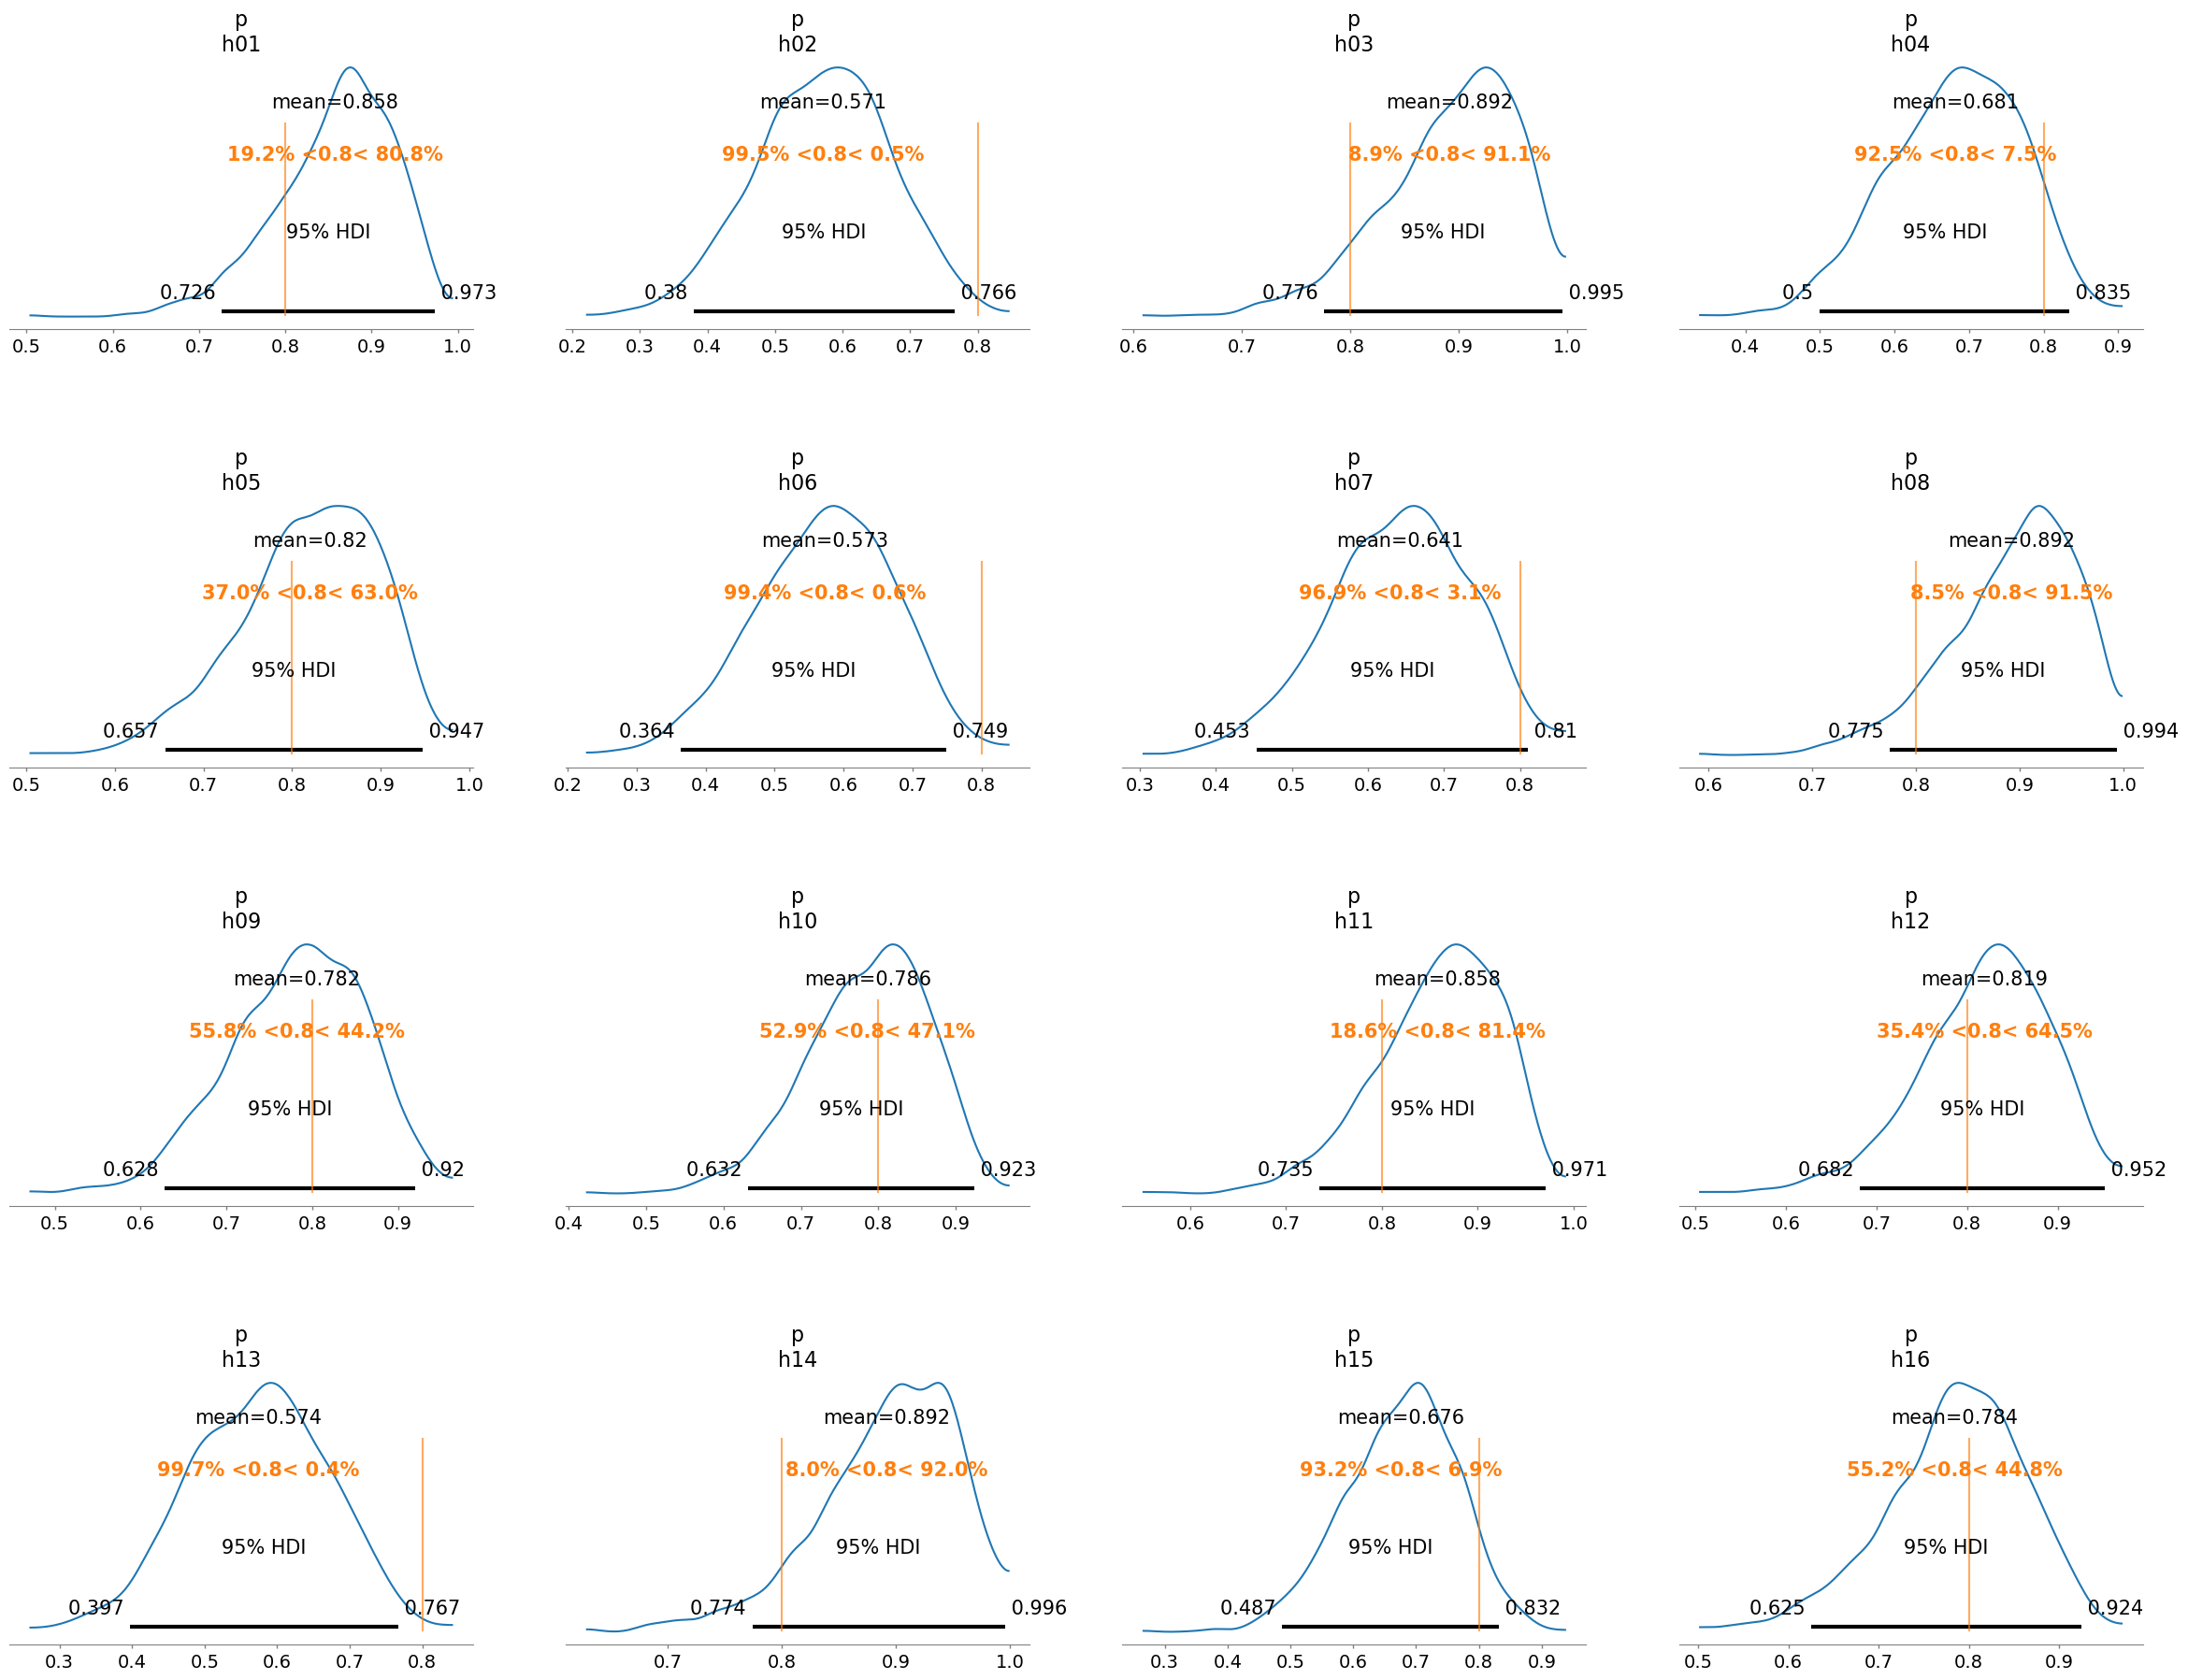

In [57]:
az.plot_posterior(idata_bb3, hdi_prob=0.95, ref_val=0.8, round_to=3, figsize=(25, 15),
                  var_names=["p"])

plt.subplots_adjust(hspace=0.6)
plt.show()

1.整體藥效? 範圍? Overall effect:  $\pi(\theta|\mathop{y}\limits_{\sim})$

2.醫院之間藥效有差異嗎?   Heterogeneity:  $\pi(\omega| \mathop{y}\limits_{\sim})$

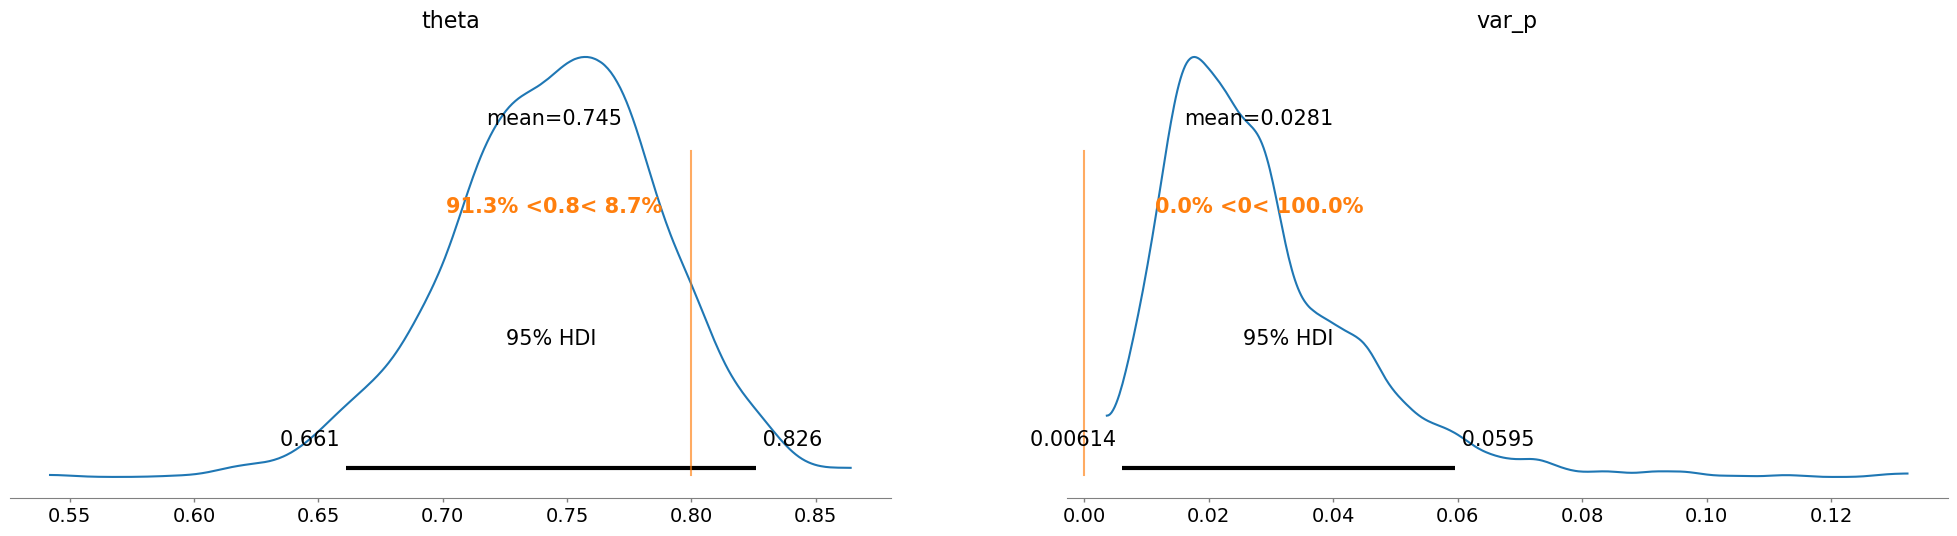

In [73]:
az.plot_posterior(idata_bb3, hdi_prob=0.95, ref_val=[0.8,0], round_to=3, figsize=(25,6),
                  var_names=["theta","var_p"])
plt.show()

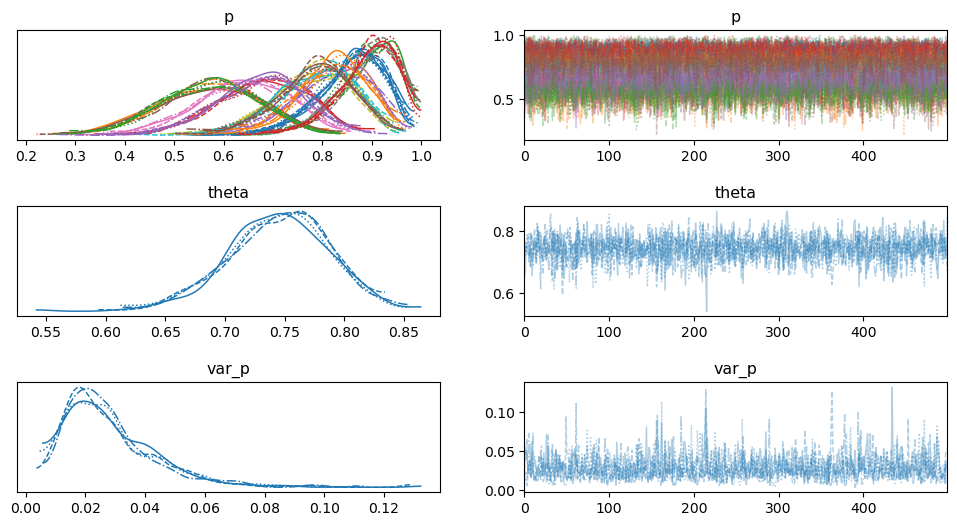

In [90]:
az.plot_trace(idata_bb3,var_names=["p","theta","var_p"])
plt.subplots_adjust(hspace=0.6)
plt.show()

### Beta-Binomial models (4)

16家醫院參加某癌症藥物的臨床試驗，每家招募20人，假設藥效成功率為 $\textcolor{red}{p_i}$ ，請問該藥效能勝過傳統藥物藥效0.8的機率為多少?

Different effects $\textcolor{red}{p_i}$ for $K=16$ centers:

Likelihood  & prior:
\begin{align*}
      Y_i \mid \textcolor{red}{p_i} &\sim \text{Binomial}(n=20, \textcolor{red}{p_i}) \\
      \textcolor{red}{p_i} \mid \alpha, \beta  &\sim \text{Beta}(\alpha , \beta)\\ 
\end{align*} 
Hyper prior:
\begin{align*}
      \alpha  &\sim \text{Gamma}( 8, 2)\\
      \beta &\sim \text{Exponential}(0.1)
\end{align*}


Target為
\begin{align*}
E(p_i) &= \alpha /(\alpha + \beta) \\
Var(p_i) &= \alpha \beta / (\alpha + \beta)^2(\alpha + \beta +1)
\end{align*}

- $Y_i$: number of success ,      $i=1,...,K$ 
- $\color{red}{p_i}$: effect $\color{red}{p}$ (success rate) for center $i$,  $i=1,...,K$
- $n$: (n=20) number of patient in each centers)

In [78]:
coords = {"Hospital": Hosp_labels,        # Label/Name for the hospital 
          "Hosp_idx":Hosp_idx,            # Index for the hospital
         "obs_id": np.arange(len(bb_df))} # Index for the dataframe

In [79]:
with pm.Model(coords=coords) as m_bb4: 
    # Hyper parameters (hyper-prior)
    alpha= pm.Gamma('alpha', alpha=8, beta=2)
    beta= pm.Exponential('beta',lam=0.1) 

    E_p=pm.Deterministic("E_p", alpha/(alpha+beta))
    var_p=pm.Deterministic("var_p", (alpha*beta) / ((alpha+beta)*(alpha+beta)*(alpha+beta+1))
                          )          
    #prior
    p = pm.Beta('p', alpha=alpha, beta=beta, dims="Hospital")

    #likelihood
    y = pm.Binomial('y', n=20, p=p[Hosp_idx], observed=bb_df["Success"], dims="obs_id")

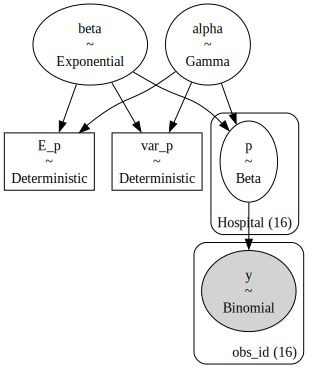

In [80]:
pm.model_to_graphviz(model=m_bb4)

In [81]:
gv = pm.model_graph.model_to_graphviz(model=m_bb4)
gv.format = 'png'
gv.render(filename='ex_3_4_hospital')

'ex_3_4_hospital.png'

In [82]:
with m_bb4: 
    idata_bb4 = pm.sample(draws=500, random_seed=101)
az.summary(idata_bb3, hdi_prob=0.95).round(2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, p]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 17 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.74,0.04,0.66,0.83,0.00,0.00,2269.0,1596.0,1.00
omega,0.15,0.08,0.03,0.28,0.00,0.00,1234.0,885.0,1.00
p[h01],0.86,0.07,0.73,0.97,0.00,0.00,3071.0,1199.0,1.00
p[h02],0.57,0.10,0.38,0.77,0.00,0.00,2903.0,1632.0,1.00
p[h03],0.89,0.06,0.78,1.00,0.00,0.00,2589.0,1244.0,1.00
p[h04],0.68,0.09,0.50,0.84,0.00,0.00,3357.0,1563.0,1.00
p[h05],0.82,0.08,0.66,0.95,0.00,0.00,3922.0,1212.0,1.00
p[h06],0.57,0.10,0.36,0.75,0.00,0.00,3253.0,1544.0,1.00
p[h07],0.64,0.09,0.45,0.81,0.00,0.00,3453.0,1179.0,1.00
p[h08],0.89,0.06,0.78,0.99,0.00,0.00,2585.0,1138.0,1.00


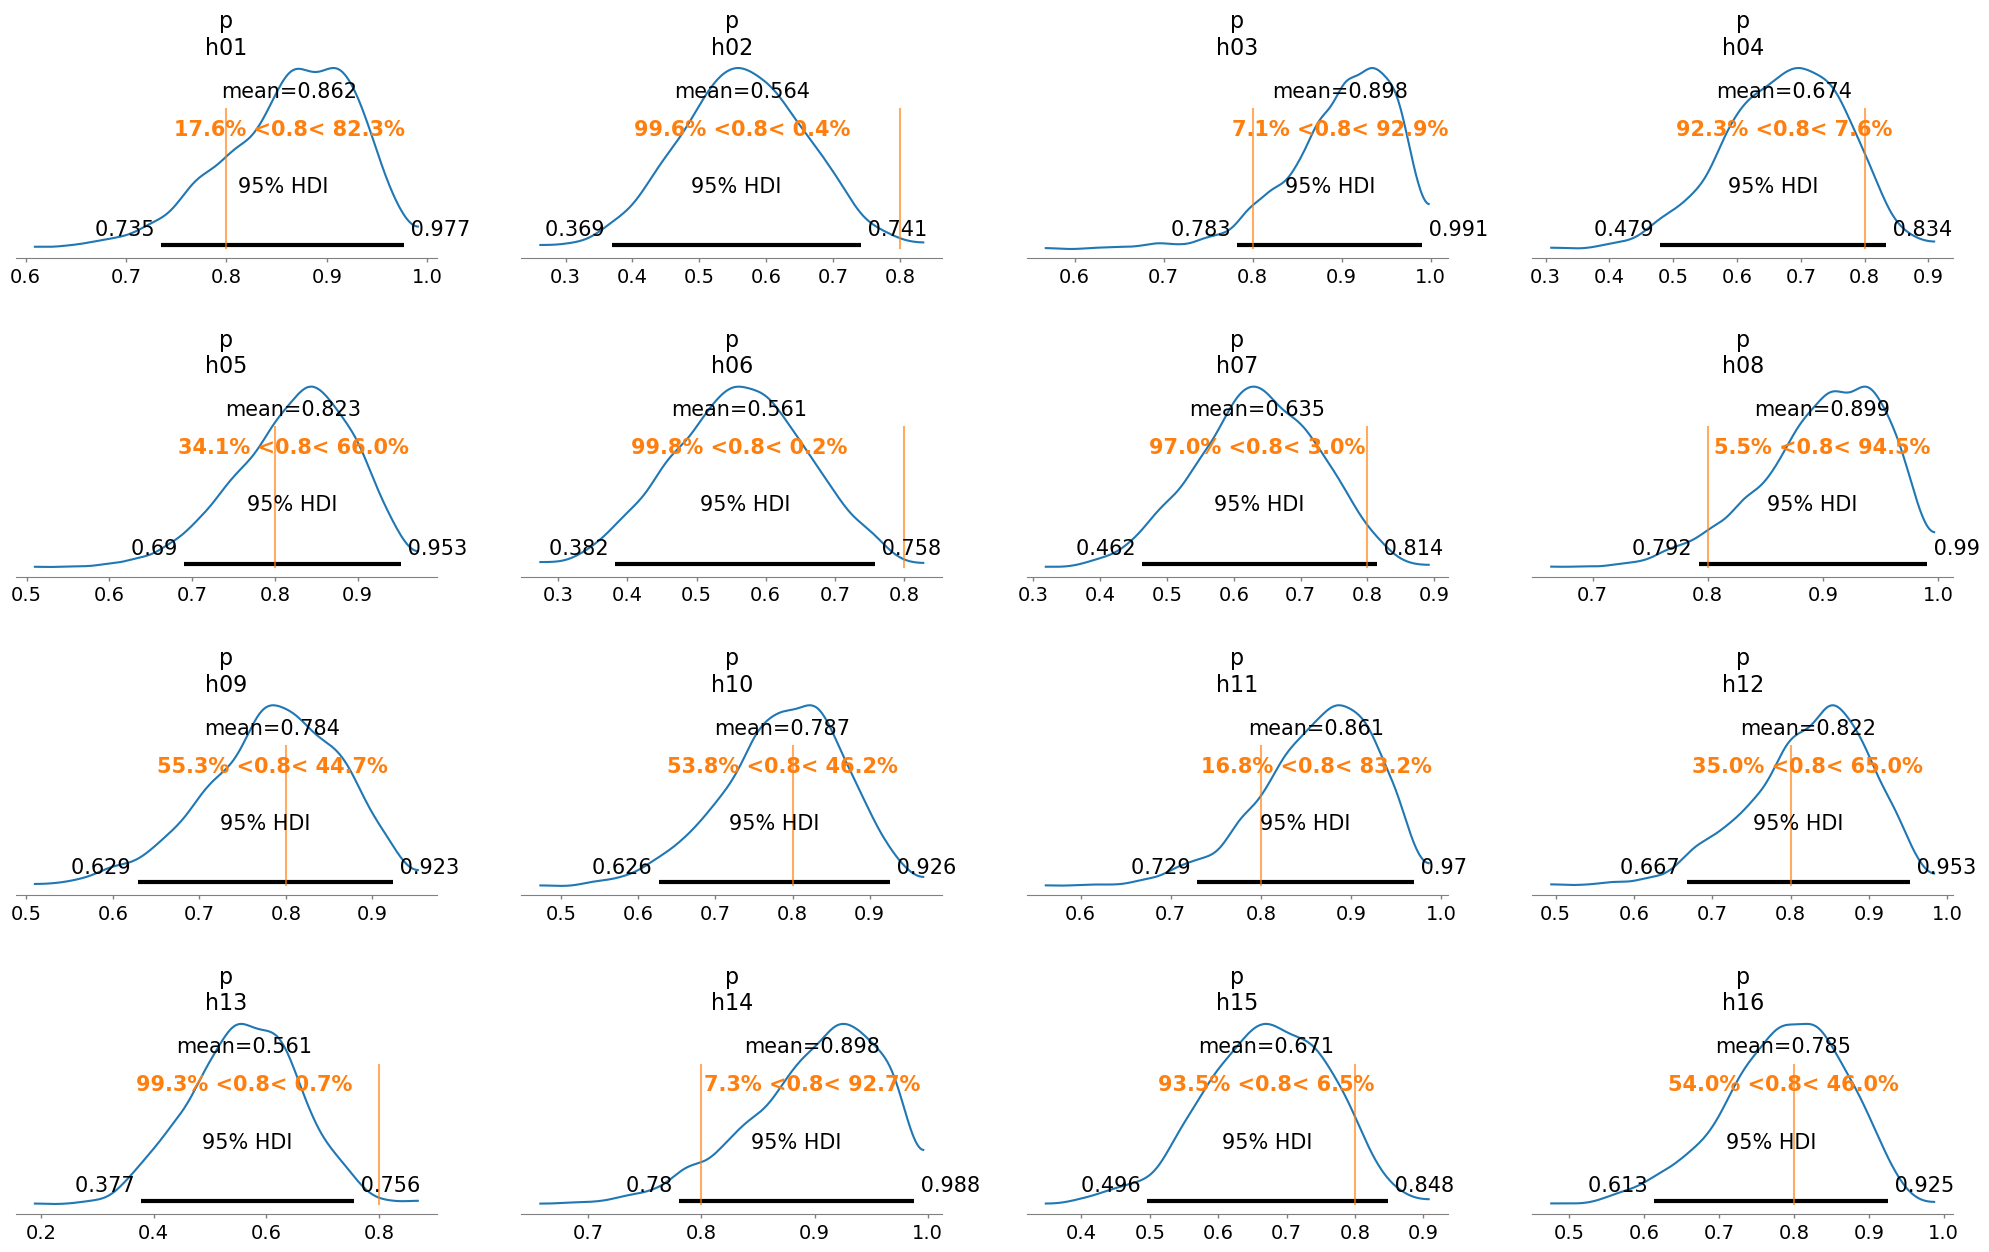

In [83]:
az.plot_posterior(idata_bb4, hdi_prob=0.95, ref_val=0.8, round_to=3, figsize=(25, 15),var_names=["p"])
plt.subplots_adjust(hspace=0.6)
plt.show()

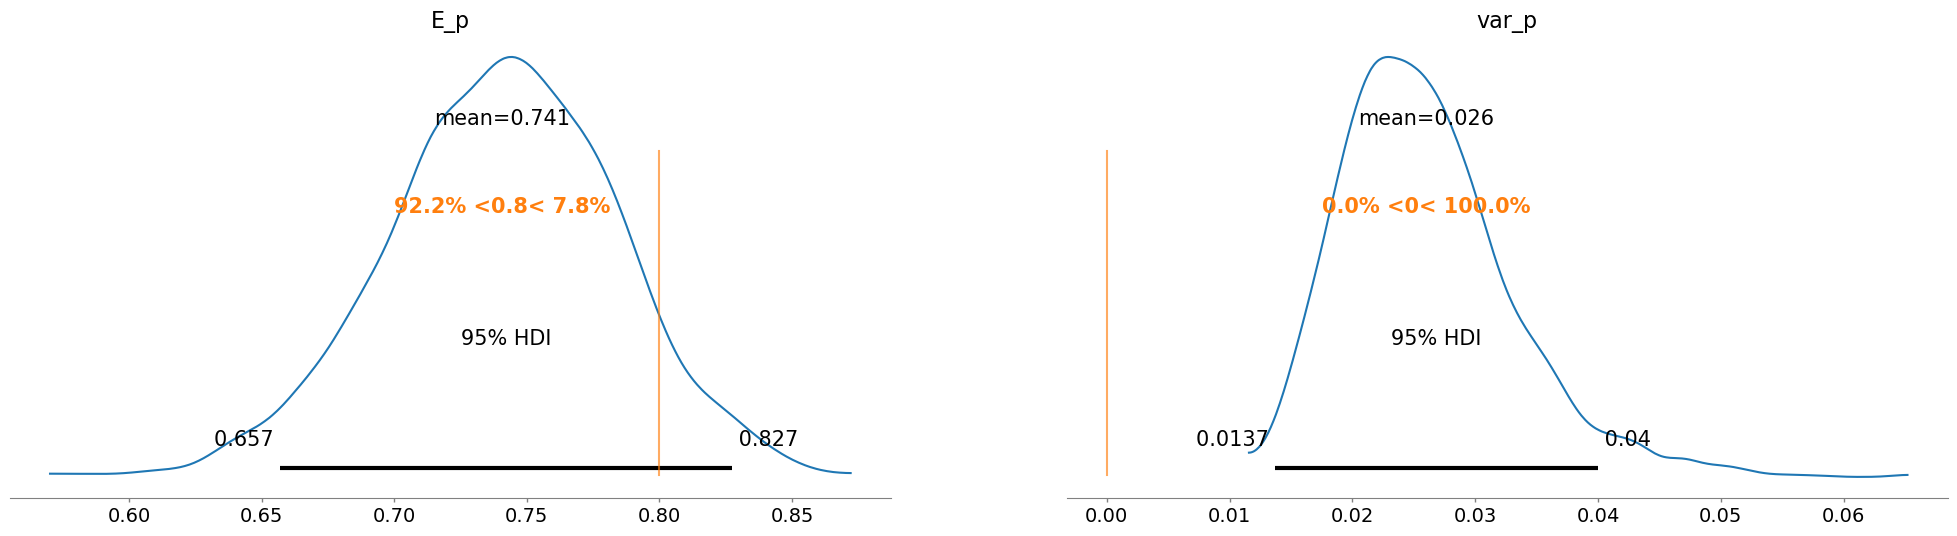

In [85]:
az.plot_posterior(idata_bb4, hdi_prob=0.95, ref_val=[0.8,0], round_to=3, figsize=(25,6),
                  var_names=["E_p","var_p"])
plt.show()

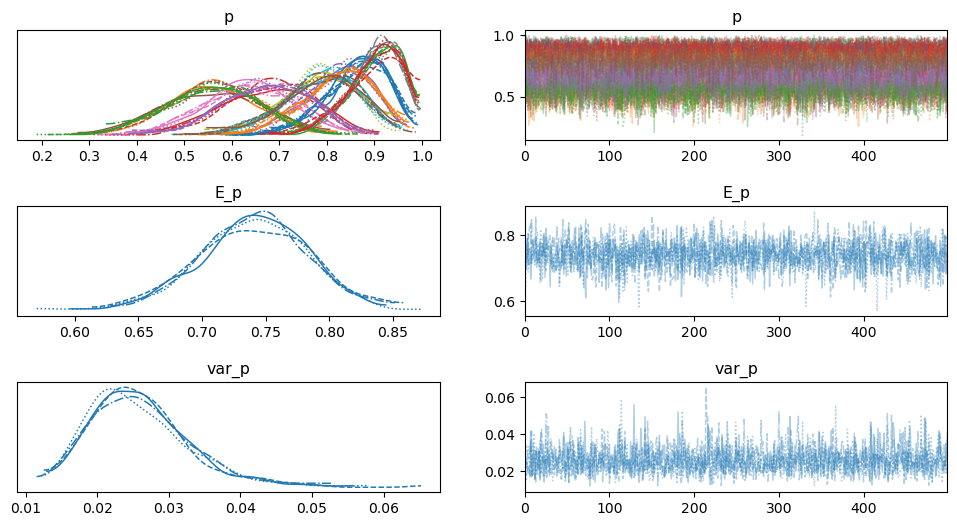

In [91]:
az.plot_trace(idata_bb4,var_names=["p","E_p","var_p"])
plt.subplots_adjust(hspace=0.6)
plt.show()